In [8]:
#import relevant libraries
import numpy as np
import emcee
import pandas as pd
import matplotlib.pyplot as plt
import corner


In [9]:
#set iPTF16hvw redshit and B band max
z_16hvw = .03663

MJD_max_16hvw = 57714.40

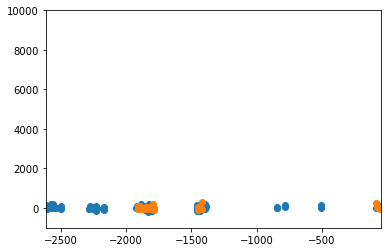

0       -55.53540
1       129.55300
2       -30.07760
3        44.10110
4       119.95300
5        28.69410
6        32.24460
7         7.47144
8       139.19700
9       212.20300
10      155.95100
12       38.56010
13       15.88030
14      129.23600
16       78.10100
17       41.59690
18      150.03100
19       34.43880
20       -4.03452
21      198.79000
22      -10.83290
23       20.08480
24      -40.07460
25      100.32200
26      -29.69990
27      -27.31070
28       82.13090
29       30.53650
30       53.89920
31       60.90520
          ...    
106      67.20280
107     -14.11460
108     142.67900
109      65.22280
110     139.28100
111      13.66210
112       8.73156
113     198.90300
114     106.17400
115     129.46200
116     -19.81180
117     -20.16650
118      92.45960
119      49.99470
120      -7.77200
121      -2.44460
122      54.81200
124      77.41410
125      13.51430
126     -33.16980
127     -50.44210
128      93.38150
129     116.27900
130      83.60850
131     13

In [27]:
#import the data
g = pd.read_csv('../Data/16hvw_photometry/16hvw_g_forced_flux.txt', sep=" " , header=None)
R = pd.read_csv('../Data/16hvw_photometry/16hvw_R_forced_flux.txt', sep=" " , header=None)

#convert to MJD
g[0] = g[0] - 2400000.5
R[0] = R[0] - 2400000.5

#convert times relative to SN max light in restframe
g[0] = (g[0] - MJD_max_16hvw) / (1 + z_16hvw)
R[0] = (R[0] - MJD_max_16hvw) / (1 +z_16hvw)

#Set column names 
g.columns = ['phase' , 'Flux' ,'Fluxerr']
R.columns =  ['phase' , 'Flux' ,'Fluxerr']


#get rid of bad data
R_bad_indices = np.where(np.logical_or(R['Fluxerr']< 0, R['Flux'] == 99999999.0))
g_bad_indices = np.where(np.logical_or(g['Fluxerr']< 0, g['Flux'] == 99999999.0))

R.drop(index=R_bad_indices[0], inplace=True)
g.drop(index=g_bad_indices[0], inplace=True)

#Get rid of post peak data
g = g[:-4]
R = R[:-4]

#plot data 
plt.errorbar(R['phase'],  R['Flux'], yerr=R['Fluxerr'], fmt='o' )
plt.errorbar(g['phase'] , g['Flux'], yerr=g['Fluxerr'], fmt ='o')
plt.xlim([np.min(R['phase']), -50])
plt.ylim([-1000,10000])
plt.show()
R['Flux']

In [11]:
def makeCorner(sampler, nburn, paramsNames, quantiles=[0.16, 0.5, 0.84]):
    samples = sampler.chain[:, nburn:, :].reshape((-1, len(paramsNames)))
    f = corner.corner(samples, labels = paramsNames, quantiles = quantiles)
    
def plotChains(sampler, nburn, paramsNames):
    Nparams = len(paramsNames)
    fig, ax = plt.subplots(Nparams,1, figsize = (8,2*Nparams), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = range(len(sampler.chain[0,:,0]))

    for i,p in enumerate(paramsNames):
        for w in range(sampler.chain.shape[0]):
            ax[i].plot(xplot[:nburn], sampler.chain[w,:nburn,i], color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.chain[w,nburn:,i], color="k", alpha = 0.4, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            
    return ax

paramsNames=['a', 
           'b', 't_0', 'alpha', 'sig_0']

# likelihood function

# <center> $\prod_{i} \frac{1}{\sqrt{\pi ( \sigma_{i}^{2} + \sigma_{0}^{2}})} exp\bigg(\frac{-(y_{i} - (a + b(t-t_{0})^{\alpha}))}{\sigma_{i}^{2} + \sigma_{0}^{2}}\bigg) $
</centering>

# <center>$\prod_{i} \frac{1}{\sqrt{\pi ( \sigma_{i}^{2} + \sigma_{0}^{2} })} exp\bigg(\frac{-(y_{i} - a )}{\sigma_{i}^{2} + \sigma_{0}^{2}}\bigg)$
    
   

In [12]:
#Define the log likelihood
def lnlikelihood(theta, f, t, f_err):
    a, b, t_0, alpha, sig_0 = theta
    ln_l = 0
    for i in range(len(t)):
        if(t[i] < t_0):
            model = a
        elif(t[i] > t_0):
            model = a + (b*((t[i] - t_0)**alpha))
        ln_l += np.log(1. / np.sqrt(2*np.pi * (sig_0**2 + f_err[i]**2))) - ((f[i] - model)**2 / (2 * (sig_0**2 + f_err[i]**2)))
    return ln_l

#Define priors on parameters  
def lnprior(theta):
    a, b, t_0, alpha, sig_0 = theta
    if(-25 < t_0 < -10 and 0 < alpha < 5 and 0 < sig_0 < 100 and -100 < a < 100 and  0 < b < 100):
        return 0.0
    return -np.inf
   
def posterior(theta, f, t, f_err):
    prior = lnprior(theta)
    lnl = lnlikelihood(theta, f, t, f_err)
    if not np.isfinite(lnl):
        return -np.inf
    if not np.isfinite(prior):
        return -np.inf
    return lnl + prior
    
   

In [13]:
#initial guess on parameters
guess_0 = [30 , 1 ,-16, 2, 100]



In [14]:
nwalkers = 100
nfac = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
ndim = len(guess_0)
ncores=6
pos = [guess_0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]
sampler_R = emcee.EnsembleSampler(nwalkers, ndim, posterior, args=(np.array(R['Flux']), np.array(R['phase']) , np.array(R['Fluxerr'])), threads = ncores)

nsamples = 10000
foo = sampler_R.run_mcmc(pos, nsamples)


In [26]:
# set a "burn-in" limit
nburn = 4000
alpha_samples_R = np.array(sampler_R.chain[:,:nburn,3]).flatten()
t_0_samples_R = np.array(sampler_R.chain[:,:nburn,2]).flatten()

#print the results taking 1-sigma confidence intervals
samples_R = np.vstack([t_0_samples_R, alpha_samples_R]).T

t_0_mc_R, alpha_mc_R = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples_R, [16, 50, 84], axis=0)))
print("emcee results with 1-sigma uncertainties\n \
      t_0 = {:.4f} +{:.4f} -{:.4f}\n \
      alpha = {:.4f} +{:.4f} -{:.4f}\n" \
      .format(t_0_mc_R[0], t_0_mc_R[1], t_0_mc_R[2], alpha_mc_R[0], alpha_mc_R[1], alpha_mc_R[2]))

emcee results with 1-sigma uncertainties
       t_0 = -19.1147 +0.9789 -1.2659
       alpha = 2.4064 +0.6848 -0.5666



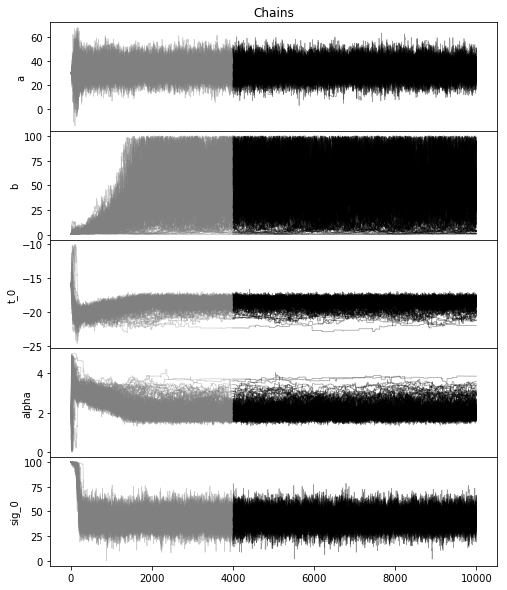

In [16]:
axR = plotChains(sampler_R, nburn, paramsNames)
plt.savefig('Chains')
plt.show()


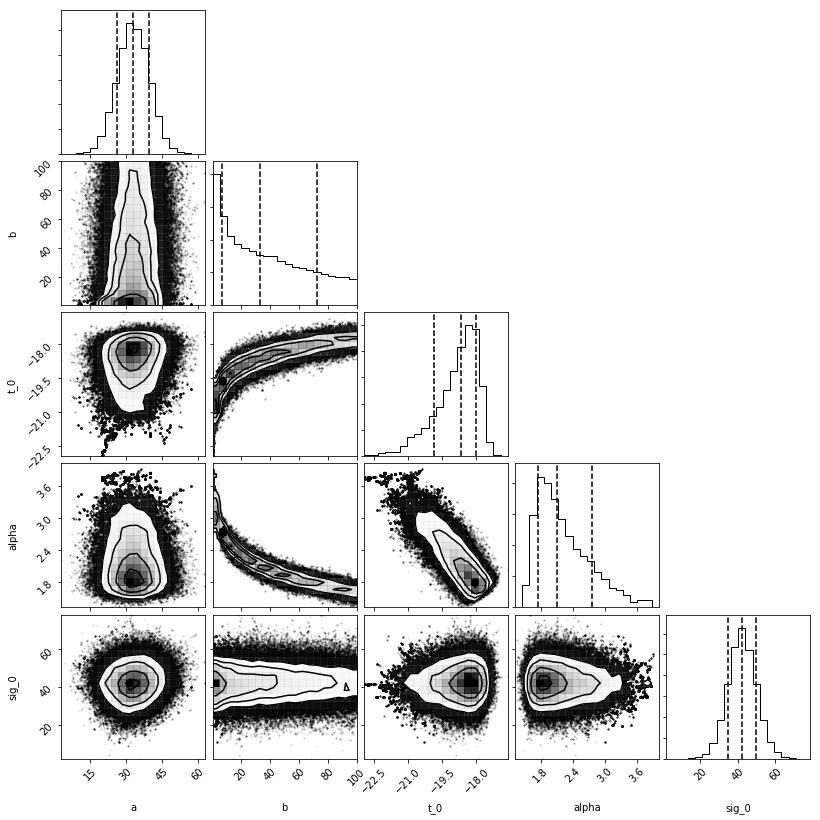

In [17]:
makeCorner(sampler_R, nburn, paramsNames)
plt.show()

In [18]:
sampler_g = emcee.EnsembleSampler(nwalkers, ndim, posterior, args=(np.array(g['Flux']), np.array(g['phase']) , np.array(g['Fluxerr'])), threads = ncores)
nsamples = 10000
foo2 = sampler_g.run_mcmc(pos, nsamples)


In [19]:
alpha_samples_g = np.array(sampler_g.chain[:,:nburn,3]).flatten()
t_0_samples_g = np.array(sampler_g.chain[:,:nburn,2]).flatten()

#print the results taking 1-sigma confidence intervals
samples_g = np.vstack([t_0_samples_g, alpha_samples_g]).T

t_0_mc_g, alpha_mc_g = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples_g, [16, 50, 84], axis=0)))
print("emcee results with 1-sigma uncertainties\n \
      t_0 = {:.4f} +{:.4f} -{:.4f}\n \
      alpha = {:.4f} +{:.4f} -{:.4f}\n" \
      .format(t_0_mc_g[0], t_0_mc_g[1], t_0_mc_g[2], alpha_mc_g[0], alpha_mc_g[1], alpha_mc_g[2]))

emcee results with 1-sigma uncertainties
       t_0 = -19.0546 +0.9245 -1.0017
       alpha = 2.3886 +0.5585 -0.5246



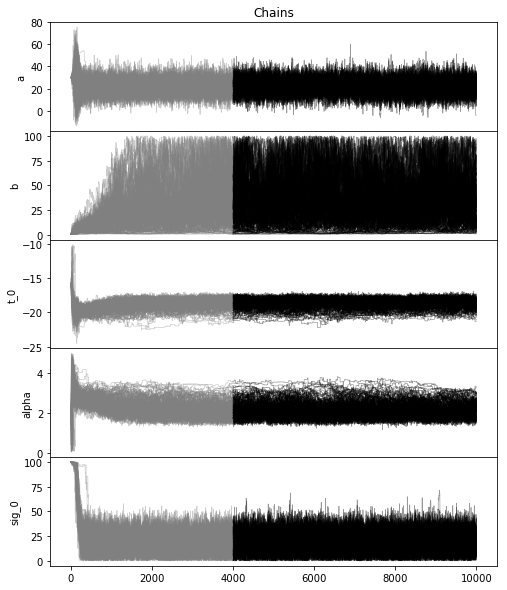

In [20]:
ax = plotChains(sampler_g, nburn, paramsNames)
plt.show()


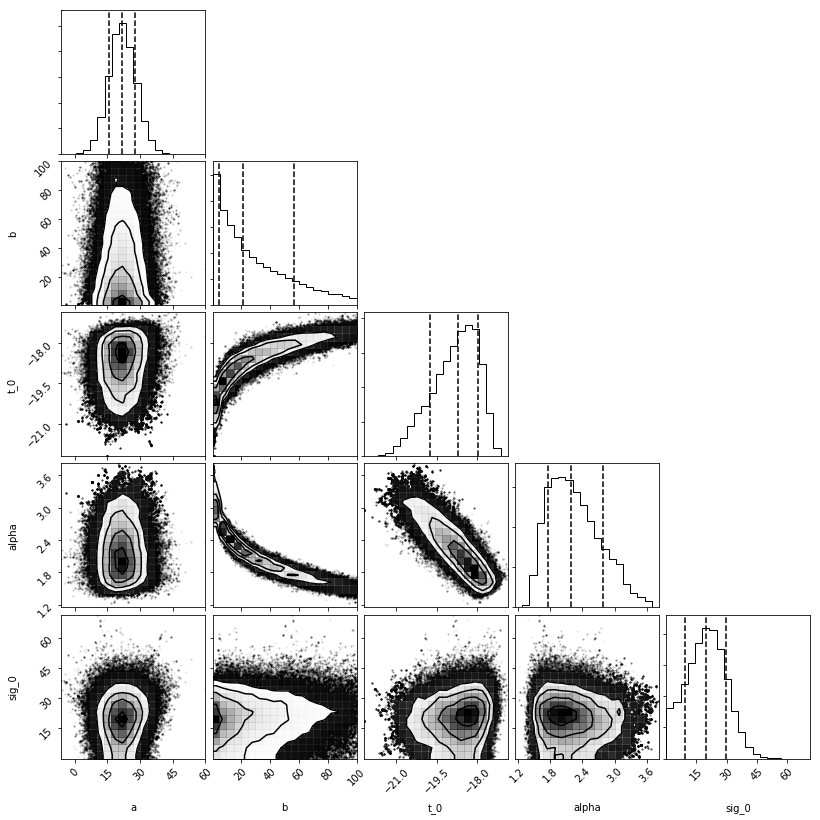

In [21]:
makeCorner(sampler_g, nburn, paramsNames)
plt.show()

In [22]:
print("g data results\n \
      t_0 = {:.4f} +{:.4f} -{:.4f}\n \
      alpha = {:.4f} +{:.4f} -{:.4f}\n" \
      .format(t_0_mc_g[0], t_0_mc_g[1], t_0_mc_g[2], alpha_mc_g[0], alpha_mc_g[1], alpha_mc_g[2]))

print("R data results\n \
      t_0 = {:.4f} +{:.4f} -{:.4f}\n \
      alpha = {:.4f} +{:.4f} -{:.4f}\n" \
      .format(t_0_mc_R[0], t_0_mc_R[1], t_0_mc_R[2], alpha_mc_R[0], alpha_mc_R[1], alpha_mc_R[2]))

g data results
       t_0 = -19.0546 +0.9245 -1.0017
       alpha = 2.3886 +0.5585 -0.5246

R data results
       t_0 = -19.1147 +0.9789 -1.2659
       alpha = 2.4064 +0.6848 -0.5666

